<a href="https://colab.research.google.com/github/dtoralg/IE_Calidad_ML/blob/main/Ejercicios/Modulo%203/Modulo_3_Ejercicio_2_Regresion_Logistica_Clasificacion_Resuelto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Ejercicio 2: Regresión Logística para la Clasificación de Defectos**
#### Aplicación de Regresión Logística para clasificar si un circuito electrónico fallará o no

### **Introducción**
En este ejercicio, aplicaremos un modelo de Regresión Logística para predecir si un circuito electrónico fallará en una línea de producción. El objetivo es entrenar un modelo de clasificación basado en datos de calidad industrial.

In [42]:
# Celda 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Configuración de gráficos
sns.set(style='whitegrid')

### **Descripción del dataset**
Se utilizará el dataset "Control de calidad en circuitos electrónicos", que contiene información sobre diversos parámetros que pueden influir en el fallo de un circuito.

In [43]:
# Celda 2
dataset_path = "https://github.com/dtoralg/IE_Calidad_ML/raw/main/Data/control_calidad_circuitos_electronicos.csv"
data = pd.read_csv(dataset_path)

# Eliminar duplicados
data = data.drop_duplicates()

# Imputar valores faltantes en Horas_operación con la mediana
data["Horas_operación"] = data["Horas_operación"].fillna(data["Horas_operación"].median())

# Mostrar las primeras filas del dataset después de la limpieza
data.head()


<ipython-input-43-cbd7a9033668>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Horas_operación"] = data["Horas_operación"].fillna(data["Horas_operación"].median())


,ID_componente,Voltaje_operación,Corriente_fuga,Resistencia_circuito,Frecuencia_operación,Temperatura_prueba,Horas_operación,Proveedor_material,Modelo_chip,Método_prueba,Fallo_circuito
0,1,5.248357,1.934405,1055.302146,2.415568,71.648138,6826.235678,Proveedor_2,Modelo_8,Método_C,OK
1,2,4.930868,2.114882,1208.739222,2.379194,74.617461,4889.806377,Proveedor_5,Modelo_8,Método_C,OK
2,3,5.323844,2.220543,1000.776616,2.362610,83.187345,4272.656141,Proveedor_4,Modelo_10,Método_B,KO
3,4,5.761515,1.644991,792.359071,2.120637,71.668613,4639.328169,Proveedor_4,Modelo_2,Método_C,OK
4,5,4.882923,2.030222,1235.237438,2.320803,77.624833,6439.710569,Proveedor_3,Modelo_14,Método_C,OK


In [44]:
# Celda 3
# Información general del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID_componente         120000 non-null  int64  
 1   Voltaje_operación     120000 non-null  float64
 2   Corriente_fuga        120000 non-null  float64
 3   Resistencia_circuito  120000 non-null  float64
 4   Frecuencia_operación  120000 non-null  float64
 5   Temperatura_prueba    120000 non-null  float64
 6   Horas_operación       120000 non-null  float64
 7   Proveedor_material    120000 non-null  object 
 8   Modelo_chip           120000 non-null  object 
 9   Método_prueba         120000 non-null  object 
 10  Fallo_circuito        120000 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 11.0+ MB


In [45]:
# Celda 4
# Resumen estadístico
data.describe()

,ID_componente,Voltaje_operación,Corriente_fuga,Resistencia_circuito,Frecuencia_operación,Temperatura_prueba,Horas_operación
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,60000.500000,5.001079,1.999868,999.289964,2.399390,74.979864,5004.141996
std,34641.160489,0.500442,0.299512,200.334931,0.200139,10.022186,947.299947
min,1.000000,2.767198,0.675834,119.157208,1.434113,32.727682,680.535168
25%,30000.750000,4.663785,1.797377,864.409903,2.263522,68.216501,4413.295206
50%,60000.500000,5.002282,1.999652,998.926268,2.399534,74.986097,5008.187400
75%,90000.250000,5.338442,2.202259,1133.927078,2.534692,81.752594,5593.295372
max,120000.000000,7.239542,3.368634,1843.873269,3.260370,121.789491,9526.783893


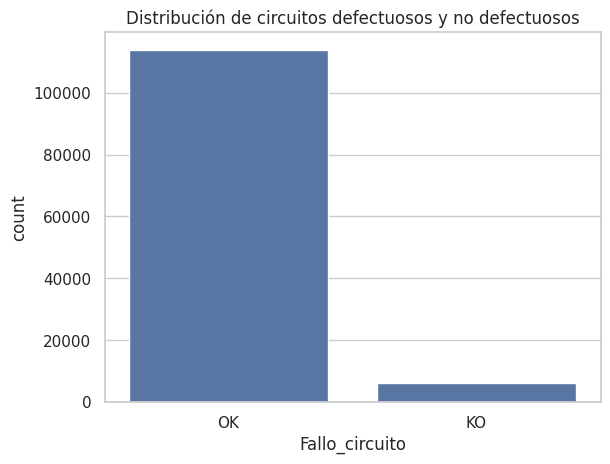

In [46]:
# Celda 5
# Distribución de la variable objetivo
sns.countplot(x='Fallo_circuito', data=data)
plt.title('Distribución de circuitos defectuosos y no defectuosos')
plt.show()

Advertimos una variable objetivo **fuertemente desbalanceada** lo cual puede impactar a la capacidad de nuestro modelo de predecir la clase KO, predominando la clase OK

### **Preparación de los datos**
Se seleccionan las variables predictoras y la variable objetivo, y se dividen los datos en entrenamiento y prueba.

In [47]:
# Convertir variables categóricas a dummies
data = pd.get_dummies(data, columns=['Proveedor_material', 'Modelo_chip', 'Método_prueba'], drop_first=True)

# Verificar la estructura del dataset después de las transformaciones
data.head()


,ID_componente,Voltaje_operación,Corriente_fuga,Resistencia_circuito,Frecuencia_operación,Temperatura_prueba,Horas_operación,Fallo_circuito,Proveedor_material_Proveedor_2,Proveedor_material_Proveedor_3,...,Modelo_chip_Modelo_3,Modelo_chip_Modelo_4,Modelo_chip_Modelo_5,Modelo_chip_Modelo_6,Modelo_chip_Modelo_7,Modelo_chip_Modelo_8,Modelo_chip_Modelo_9,Método_prueba_Método_B,Método_prueba_Método_C,Método_prueba_Método_D
0,1,5.248357,1.934405,1055.302146,2.415568,71.648138,6826.235678,OK,True,False,...,False,False,False,False,False,True,False,False,True,False
1,2,4.930868,2.114882,1208.739222,2.379194,74.617461,4889.806377,OK,False,False,...,False,False,False,False,False,True,False,False,True,False
2,3,5.323844,2.220543,1000.776616,2.362610,83.187345,4272.656141,KO,False,False,...,False,False,False,False,False,False,False,True,False,False
3,4,5.761515,1.644991,792.359071,2.120637,71.668613,4639.328169,OK,False,False,...,False,False,False,False,False,False,False,False,True,False
4,5,4.882923,2.030222,1235.237438,2.320803,77.624833,6439.710569,OK,False,True,...,False,False,False,False,False,False,False,False,True,False


In [48]:
# Celda 6
# Definir variables predictoras y objetivo
X = data.drop(columns=["Fallo_circuito"])
y = data["Fallo_circuito"].map({"OK": 0, "KO": 1})  # Convertir a valores binarios 0 y 1

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### **Entrenamiento del modelo**
Se entrena un modelo de Regresión Logística con los datos de entrenamiento.

In [49]:
# Celda 7
# Crear y entrenar el modelo
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### **Generacion de predicciones**
Se generan las predicciones del modelo

In [51]:
# Celda 8
y_pred = modelo.predict(X_test)

# Crear una copia del DataFrame original de test para evitar modificar el original
df_predicciones = X_test.copy()

# Añadir la columna de valores reales
df_predicciones["Real"] = y_test.values

# Añadir la columna de valores predichos
df_predicciones["Predicho"] = y_pred

# Mostrar las primeras filas
df_predicciones.head(5)

,ID_componente,Voltaje_operación,Corriente_fuga,Resistencia_circuito,Frecuencia_operación,Temperatura_prueba,Horas_operación,Proveedor_material_Proveedor_2,Proveedor_material_Proveedor_3,Proveedor_material_Proveedor_4,...,Modelo_chip_Modelo_5,Modelo_chip_Modelo_6,Modelo_chip_Modelo_7,Modelo_chip_Modelo_8,Modelo_chip_Modelo_9,Método_prueba_Método_B,Método_prueba_Método_C,Método_prueba_Método_D,Real,Predicho
66341,66342,4.676394,2.120808,931.263106,2.379513,66.207510,5008.187400,False,False,False,...,False,False,False,False,False,False,False,True,0,0
119396,119397,4.895520,2.010852,824.639942,2.591039,68.079583,3887.331298,False,True,False,...,False,False,False,False,False,True,False,False,0,0
12593,12594,6.484755,1.537837,1168.813510,2.740927,85.195045,5008.187400,True,False,False,...,False,False,False,False,False,False,False,False,1,0
11200,11201,5.453417,1.598618,934.280625,2.418799,78.328710,5668.827762,False,False,False,...,False,False,False,False,False,True,False,False,0,0
32049,32050,5.901480,2.020137,876.532801,2.690329,86.796828,5287.641282,False,False,False,...,False,False,False,False,False,False,True,False,0,0


### **Conclusiones**
En este ejercicio, hemos aplicado un modelo de Regresión Logística para predecir fallos en circuitos electrónicos. Se exploraron los datos y se entrenó el modelo.


Se podrían considerar mejoras como la selección de características más relevantes, el balanceo de datos o la aplicación de modelos más avanzados como Random Forest o SVM.